<a href="https://colab.research.google.com/github/mjrakmad/MDS210_BigDataProject/blob/main/BIG_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Air Quality Data in Cotabato City Using Spark**

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **LIBRARIES**

In [34]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [35]:
sparkSession = SparkSession.builder.appName('bigdata').getOrCreate()

In [36]:
df_pyspark = sparkSession.read.csv('/content/drive/MyDrive/Dataset/CotabatoCity_AQMS.csv',
    header=True,
    inferSchema=True
)

## **DATA CLEANING**

In [37]:

# Print Schema
df_pyspark.printSchema()

# Print Dataframe
df_pyspark.show()

root
 |-- Date and Time: string (nullable = true)
 |-- Wind Speed: double (nullable = true)
 |-- Wind Direction: double (nullable = true)
 |-- Barometric Pressure: double (nullable = true)
 |-- Ambient Humidity: double (nullable = true)
 |-- Ambient Temperature: double (nullable = true)
 |-- Solar Radiation: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- PM10 Concentration: double (nullable = true)
 |-- PM25 Concentration: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOX: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- PM10 AQI: integer (nullable = true)
 |-- PM25 AQI: integer (nullable = true)
 |-- NO2 Index: integer (nullable = true)
 |-- SO2 Index: integer (nullable = true)
 |-- CO Index: string (nullable = true)
 |-- O3 Index: string (nullable = true)
 |-- AQI Index: integer (nullable = true)

+----------------+----------+

In [38]:
from pyspark.sql.functions import col, isnan, when, count

# Count missing values (null or NaN) for each column in df_pyspark
missing_values = df_pyspark.select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_pyspark.columns]
)

missing_values.show()

+-------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+---+----+---+---+--------+--------+---------+---------+--------+--------+---------+
|Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2|NOX| SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|SO2 Index|CO Index|O3 Index|AQI Index|
+-------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+---+----+---+---+--------+--------+---------+---------+--------+--------+---------+
|            0|         0|             0|                  0|               0|                  0|              0|       0|                 0|                 0|  0|  0|  0|2250|  0|  0|       0|       0|        0|     2250|       0|       0

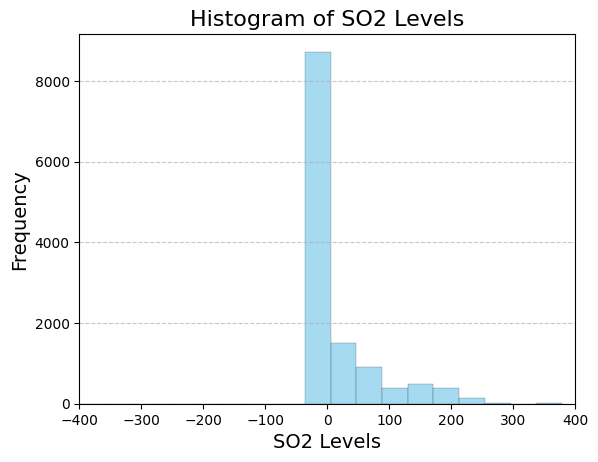

In [39]:


# Step 1: Select SO2 column and convert it to Pandas for visualization
so2_data = df_pyspark.select("SO2").dropna().toPandas()

# Step 2: Plot the histogram
sns.histplot(so2_data["SO2"], bins=250, kde=False, color="skyblue")

# Step 3: Customize the plot
plt.xlim(-400, 400)  # Set x-axis limits
plt.title("Histogram of SO2 Levels", fontsize=16)
plt.xlabel("SO2 Levels", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

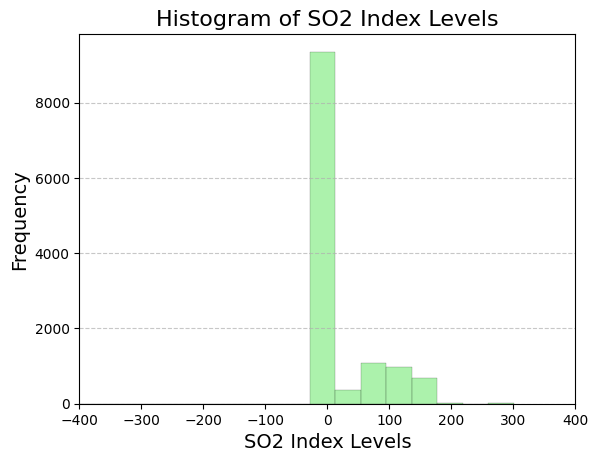

In [40]:
# Step 1: Select SO2 column and convert it to Pandas for visualization
so2_data = df_pyspark.select("SO2 Index").dropna().toPandas()

# Step 2: Plot the histogram
sns.histplot(so2_data["SO2 Index"], bins=250, kde=False, color="lightgreen")

# Step 3: Customize the plot
plt.xlim(-400, 400)  # Set x-axis limits
plt.title("Histogram of SO2 Index Levels", fontsize=16)
plt.xlabel("SO2 Index Levels", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**DATA IMPUTATION**

In [41]:
so2_median = df_pyspark.approxQuantile("SO2", [0.5], 0.0)[0]  # Median for SO2

so2_index_median = df_pyspark.approxQuantile("SO2 Index", [0.5], 0.0)[0]  # Median for SO2 Index

# Step 3: Impute missing values for both SO2 and SO2 Index
df_pyspark_imputed = df_pyspark.fillna({"SO2": so2_median, "SO2 Index": so2_index_median})

# Step 4: Show the resulting DataFrame
df_pyspark_imputed.show()

+----------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+
|   Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2| NOX|SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|SO2 Index|CO Index|O3 Index|AQI Index|
+----------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+
|06/11/2024 15:00|       2.4|         292.2|             1016.8|            52.5|             -244.7|           12.2|     0.0|              14.4|               4.3|1.6|7.7| 9.2|0.6|0.0|0.0|      13|      18|        7|        1|     

Text(0, 0.5, 'Frequency')

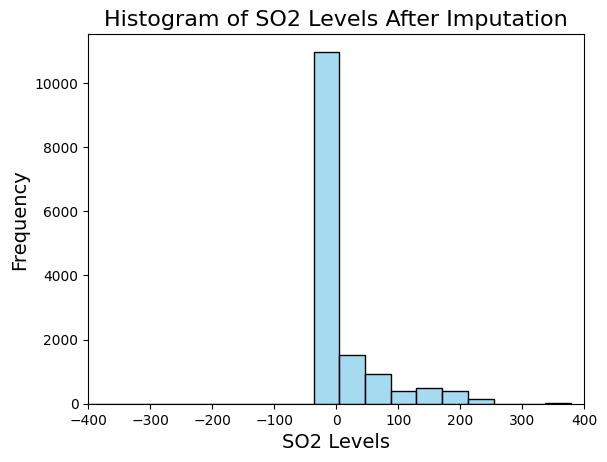

In [42]:
imputed_data = df_pyspark_imputed.select("SO2", "SO2 Index").toPandas()

# Plot histogram for SO2
plt.xlim(-400, 400)  # Set x-axis limits
sns.histplot(imputed_data["SO2"], bins=250, kde=False, color="skyblue")
plt.title("Histogram of SO2 Levels After Imputation", fontsize=16)
plt.xlabel("SO2 Levels", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

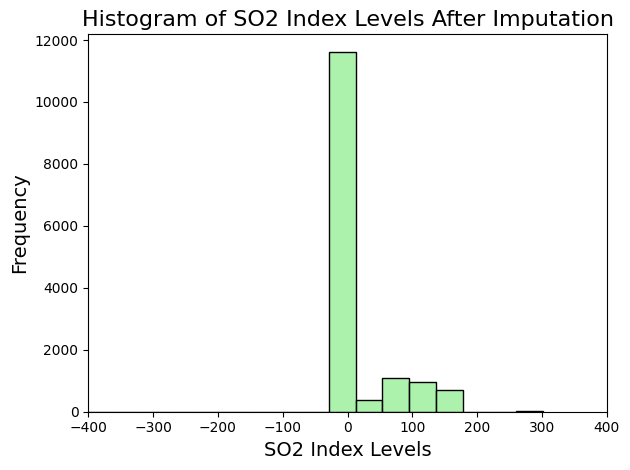

In [43]:
# Plot histogram for SO2 Index
plt.xlim(-400, 400)  # Set x-axis limits
sns.histplot(imputed_data["SO2 Index"], bins=250, kde=False, color="lightgreen")
plt.title("Histogram of SO2 Index Levels After Imputation", fontsize=16)
plt.xlabel("SO2 Index Levels", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## **OUTLIERS REMOVAL**

In [44]:
# prompt: Replace the outliers with the median for the df_pyspark_imputed

from pyspark.sql.functions import when, col, lit

def remove_outliers_with_median(df, column_name):
    # Calculate quantiles
    quantile1 = df.approxQuantile(column_name, [0.25], 0.0)[0]
    quantile3 = df.approxQuantile(column_name, [0.75], 0.0)[0]

    # Calculate IQR
    iqr = quantile3 - quantile1

    # Calculate lower and upper bounds
    lower_bound = quantile1 - 1.5 * iqr
    upper_bound = quantile3 + 1.5 * iqr

    # Calculate the median
    median = df.approxQuantile(column_name, [0.5], 0.0)[0]

    # Replace outliers with the median
    df = df.withColumn(
        column_name,
        when((col(column_name) < lower_bound) | (col(column_name) > upper_bound), median).otherwise(col(column_name))
    )
    return df

# Apply outlier removal to SO2 and SO2 Index columns
df_pyspark_imputed = remove_outliers_with_median(df_pyspark_imputed, "SO2")
df_pyspark_imputed = remove_outliers_with_median(df_pyspark_imputed, "SO2 Index")

# Display the updated DataFrame
df_pyspark_imputed.show()

+----------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+
|   Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2| NOX|SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|SO2 Index|CO Index|O3 Index|AQI Index|
+----------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+
|06/11/2024 15:00|       2.4|         292.2|             1016.8|            52.5|             -244.7|           12.2|     0.0|              14.4|               4.3|1.6|7.7| 9.2|0.6|0.0|0.0|      13|      18|        7|      1.0|     

In [45]:
# checking missing values again
from pyspark.sql.functions import col, isnan, when, count

# Count missing values (null or NaN) for each column in df_pyspark
missing_values = df_pyspark_imputed.select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_pyspark_imputed.columns]
)

missing_values.show()

+-------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+---+---+---+---+--------+--------+---------+---------+--------+--------+---------+
|Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2|NOX|SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|SO2 Index|CO Index|O3 Index|AQI Index|
+-------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+---+---+---+---+--------+--------+---------+---------+--------+--------+---------+
|            0|         0|             0|                  0|               0|                  0|              0|       0|                 0|                 0|  0|  0|  0|  0|  0|  0|       0|       0|        0|        0|       0|       0|   

## **FEATURE EXTRACTION**

In [46]:
#New Features
# extract month, day and time

from pyspark.sql.functions import date_format, to_timestamp

# Step 1: Convert "Date and Time" column to TimestampType if not already
df_pyspark = df_pyspark_imputed.withColumn("Date and Time", to_timestamp("Date and Time", "dd/MM/yyyy HH:mm"))

# Step 2: Extract the day
df_pyspark = df_pyspark.withColumn("Day", date_format("Date and Time", "dd"))

# Step 3: Extract the hour
df_pyspark = df_pyspark.withColumn("Hour", date_format("Date and Time", "HH"))

# Step 4: Extract the month
df_pyspark = df_pyspark.withColumn("Month", date_format("Date and Time", "MM"))

# Show the updated DataFrame
df_pyspark.show()

+-------------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+---+----+-----+
|      Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2| NOX|SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|SO2 Index|CO Index|O3 Index|AQI Index|Day|Hour|Month|
+-------------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+---+----+-----+
|2024-11-06 15:00:00|       2.4|         292.2|             1016.8|            52.5|             -244.7|           12.2|     0.0|              14.4|               4.3|1.6|7.7| 9.

In [47]:
from pyspark.sql.functions import when

def categorize_aqi(aqi_value):
  # Use when and otherwise for conditional logic within the PySpark DataFrame context
  return when(aqi_value <= 50, "Good").\
         when(aqi_value <= 100, "Moderate").\
         when(aqi_value <= 150, "Unhealthy for Sensitive Groups").\
         when(aqi_value <= 200, "Unhealthy").\
         when(aqi_value <= 300, "Very Unhealthy").\
         otherwise("Hazardous")

# Apply the categorize_aqi function to the 'SO2 Index' column
df_pyspark = df_pyspark.withColumn("AQI_Category", categorize_aqi(col("SO2 Index")))

df_pyspark.show()

+-------------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+---+----+-----+------------+
|      Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2| NOX|SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|SO2 Index|CO Index|O3 Index|AQI Index|Day|Hour|Month|AQI_Category|
+-------------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+---+----+-----+------------+
|2024-11-06 15:00:00|       2.4|         292.2|             1016.8|            52.5|             -244.7|           12.2|     0.0|          

## **Visualization**


**Result:**

Cleaned and standardized datasets for variables such as pollutant concentrations, AQI indices, and meteorological data.

Basic statistics (mean, median, variance) for pollutant concentrations calculated.

Identified correlations among pollutants and environmental variables.

**Visualization**

* Correlation Heatmap: A heatmap displaying correlations between variables like PM10, PM25, SO2, and Wind Speed.
*   Boxplots: Boxplot for pollutants concentrations to identify outliers and assess the distribution. For example, monthly PM10 Concentration.


**Result:**

Temporal Trends: Identified daily, hourly, and seasonal patterns in air quality.

Pollutant Hotspots: Determined periods with high pollutant levels (e.g., rush hours for PM10).

Health Risk Analysis: Categorized AQI into health risk levels (Good, Moderate, Unhealthy, etc.).

**Visualization For Trends and Patterns**


*   Line Charts for Temporal Trends
*   Heatmaps for Hourly Patterns
Bar Charts for AQI Categories
Scatter Plots for Relationships

**FINAL DASHBOARD for Stakeholders**

Goal: Provide actionable insights in a centralized format.

Dashboard Components:

Real-time AQI Trends: Display current air quality indices and categories.

Seasonal Summary: Line charts for pollutant trends over months.

Policy Recommendations: A summary card highlighting peak pollution times and contributing factors.













**CORRELATION HEATMAP**

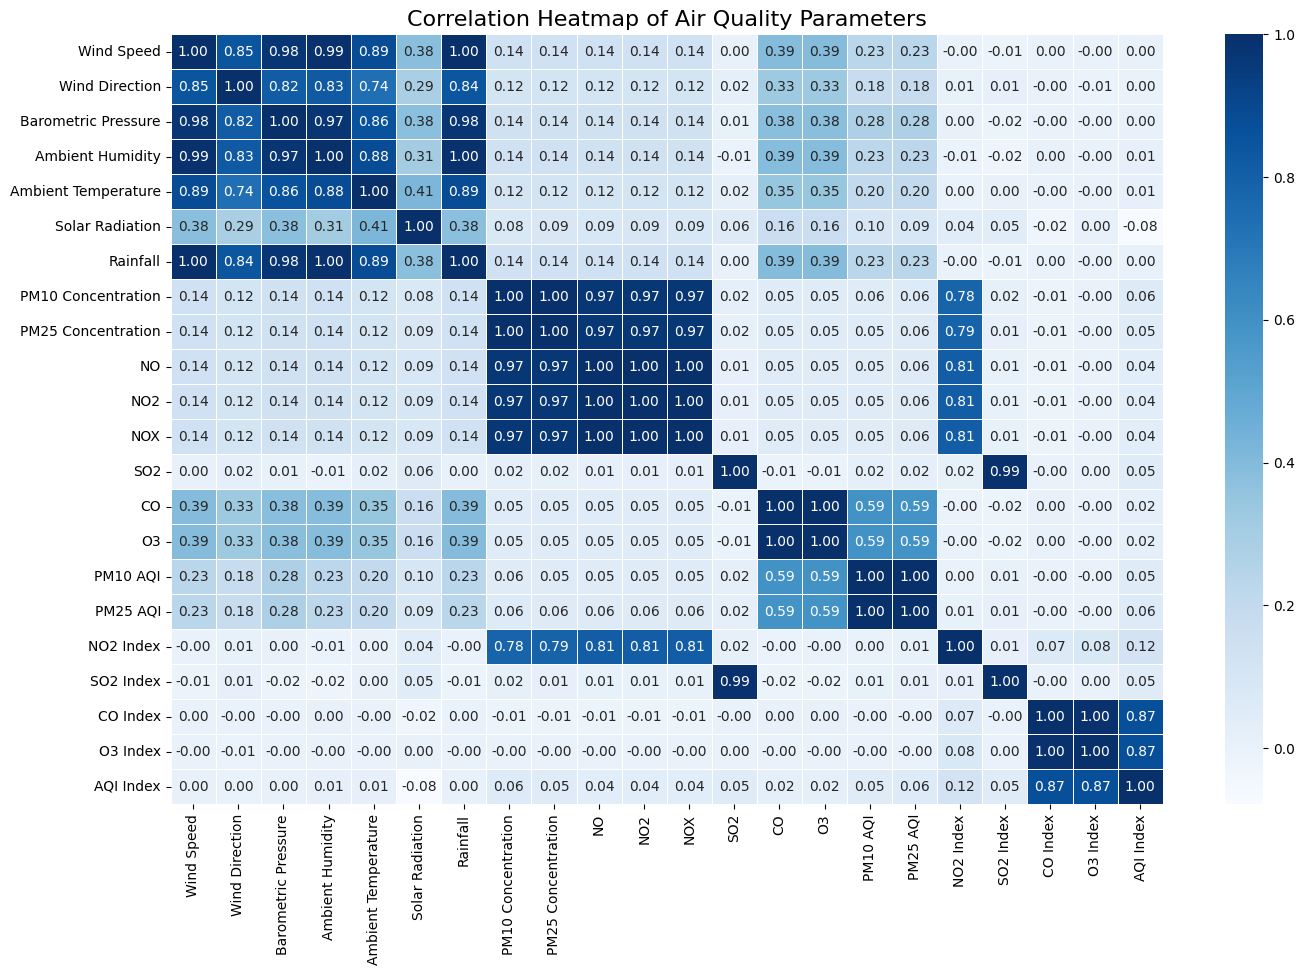

In [48]:
pandas_df = df_pyspark.toPandas()
columns_for_heatmap = ['Wind Speed', 'Wind Direction', 'Barometric Pressure',
                       'Ambient Humidity', 'Ambient Temperature', 'Solar Radiation',
                       'Rainfall', 'PM10 Concentration', 'PM25 Concentration', 'NO',
                       'NO2', 'NOX', 'SO2', 'CO', 'O3', 'PM10 AQI', 'PM25 AQI',
                       'NO2 Index', 'SO2 Index', 'CO Index', 'O3 Index', 'AQI Index']

pandas_df[columns_for_heatmap] = pandas_df[columns_for_heatmap].replace('NULL', pd.NA).apply(pd.to_numeric, errors='coerce')

correlation_matrix = pandas_df[columns_for_heatmap].corr()


plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Air Quality Parameters', fontsize=16)
plt.show()

**BOXPLOTS ON POLLUTANT CONCENTRATIONS**

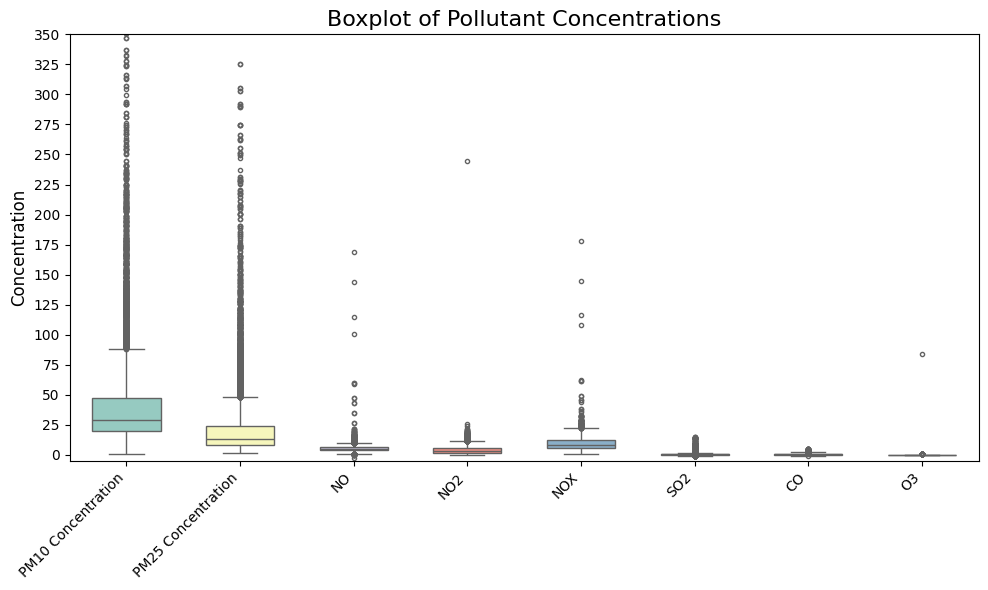

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'pandas_df' is your Pandas DataFrame (from previous code)
pollutants = ['PM10 Concentration', 'PM25 Concentration', 'NO', 'NO2', 'NOX', 'SO2', 'CO', 'O3']

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.boxplot(data=pandas_df[pollutants], palette="Set3", width=0.6, fliersize=3) # Added color and adjusted width
plt.ylim(-5, 350) # Set the y limit
plt.title('Boxplot of Pollutant Concentrations', fontsize=16)
plt.ylabel('Concentration', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout() # Adjust layout for better visualization
plt.yticks(np.arange(0, 351, 25))
plt.show()

# **Temporal Trends (Monthly, Daily, Hourly)**

**Month vs. Pollutant Concentrations**

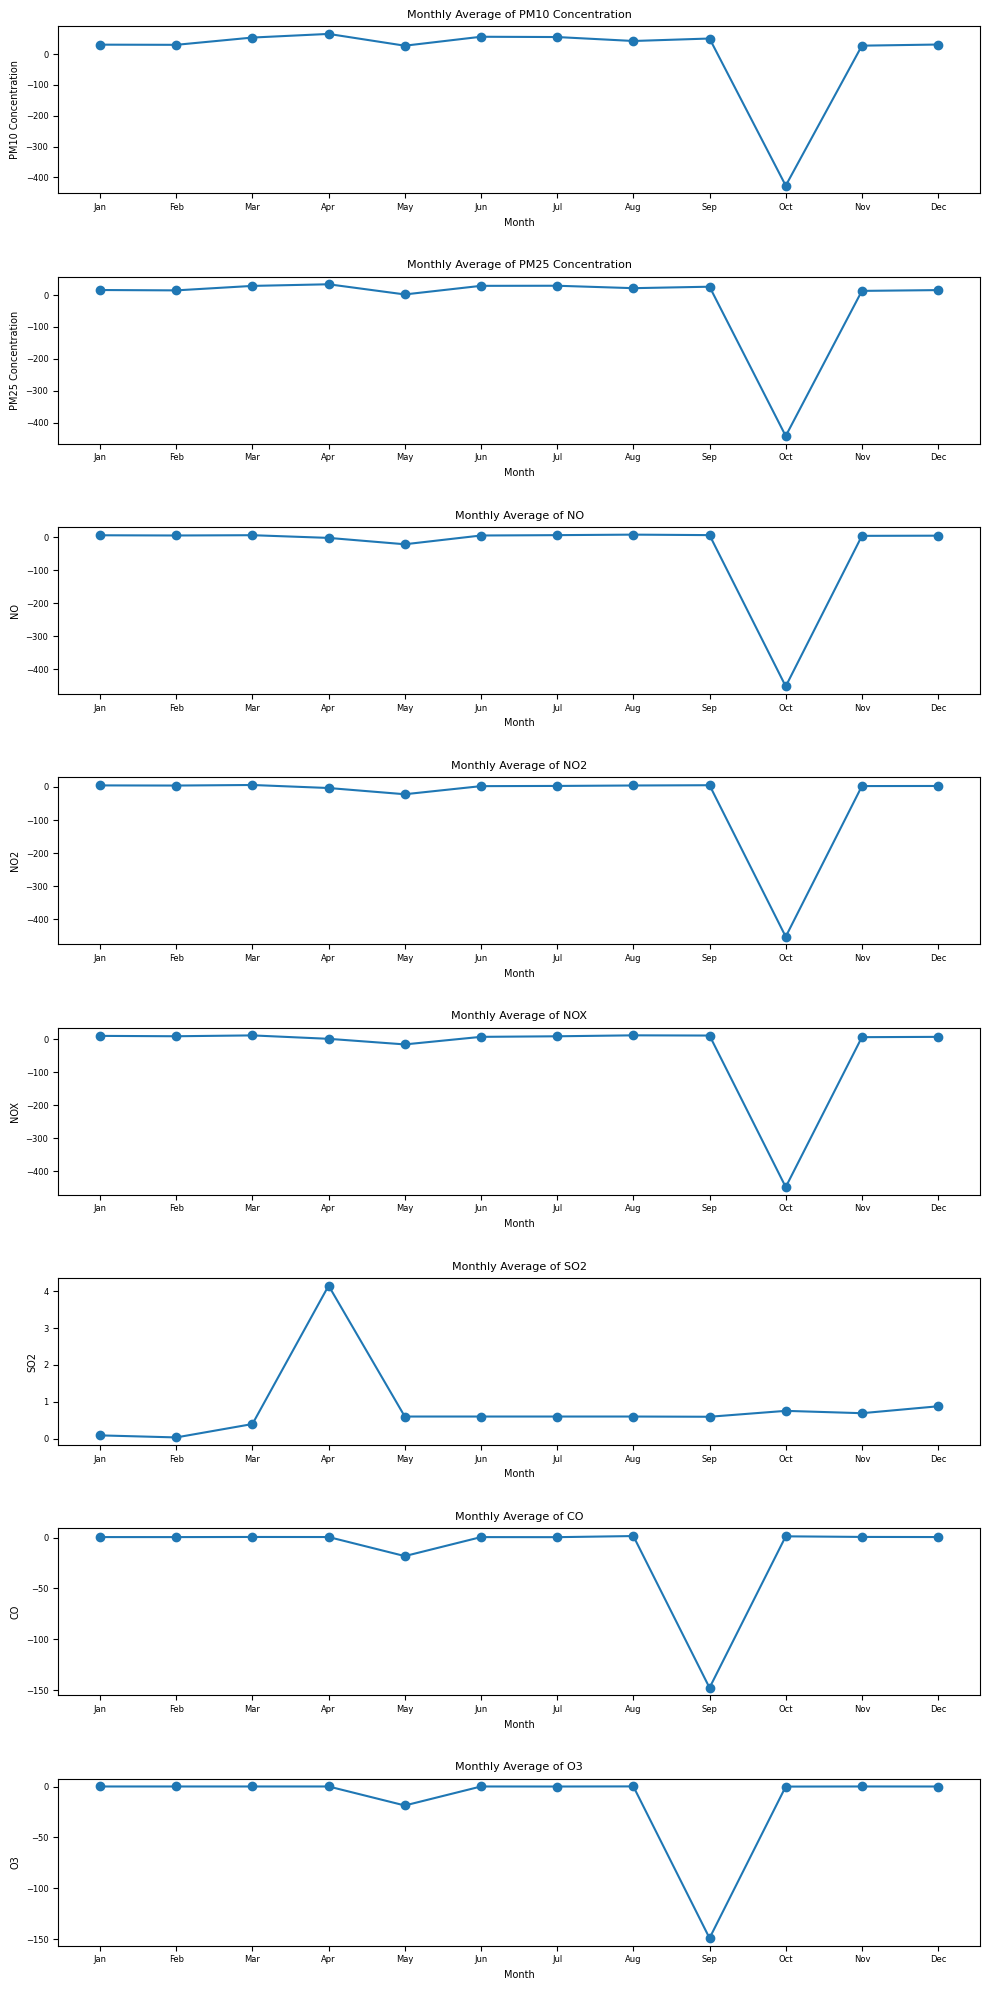

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'pandas_df' is your Pandas DataFrame and 'Month' column exists
variables = ['PM10 Concentration', 'PM25 Concentration', 'NO',
             'NO2', 'NOX', 'SO2', 'CO', 'O3']

# Convert 'Month' column to numeric if it's not already
pandas_df['Month'] = pd.to_numeric(pandas_df['Month'], errors='coerce')

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(10, 20), dpi=100)  # Adjust figure size as needed

for i, var in enumerate(variables):
    plt.subplot(len(variables), 1, i + 1)  # One column, adjust height as needed

    # Calculate monthly averages
    monthly_avg = pandas_df.groupby('Month')[var].mean()

    plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')

    plt.title(f'Monthly Average of {var}', fontsize=8)
    plt.xlabel('Month', fontsize=7)
    plt.ylabel(var, fontsize=7)

    # Set x-axis ticks to month names
    plt.xticks(range(1, 13), month_names, fontsize=6)  # Use month names for x-ticks
    plt.yticks(fontsize=6)  # Adjust y-axis tick font size

    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()


**Day vs. Pollutant Concentrations**

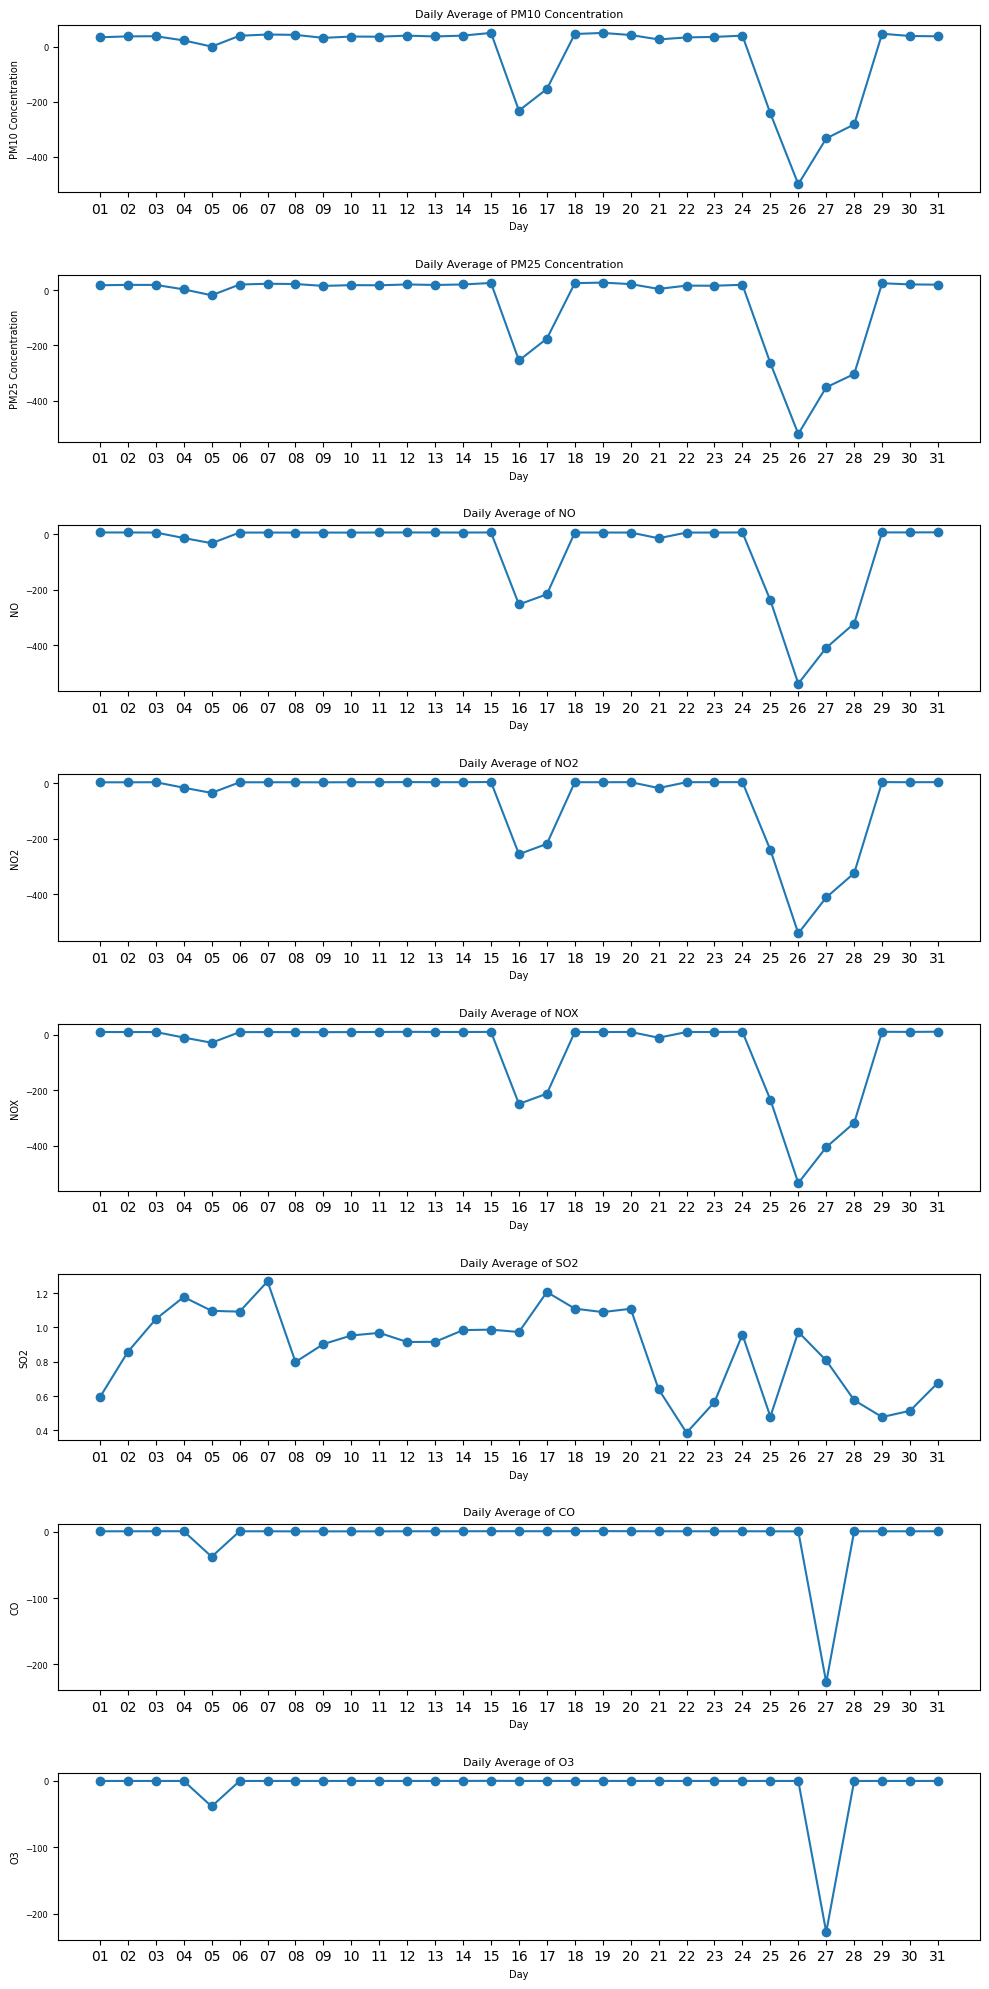

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'pandas_df' is your Pandas DataFrame and 'Month' column exists
variables = ['PM10 Concentration', 'PM25 Concentration', 'NO',
             'NO2', 'NOX', 'SO2', 'CO', 'O3']

# Convert 'Month' column to numeric if it's not already
pandas_df['Month'] = pd.to_numeric(pandas_df['Day'], errors='coerce')

plt.figure(figsize=(10, 20), dpi=100)  # Adjust figure size as needed

for i, var in enumerate(variables):
    plt.subplot(len(variables), 1, i + 1)  # One column, adjust height as needed

    # Calculate monthly averages
    monthly_avg = pandas_df.groupby('Day')[var].mean()

    plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')

    plt.title(f'Daily Average of {var}', fontsize=8)
    plt.xlabel('Day', fontsize=7)
    plt.ylabel(var, fontsize=7)

    plt.yticks(fontsize=6)  # Adjust y-axis tick font size

    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()

**Hour vs. Pollutant Concentrations**

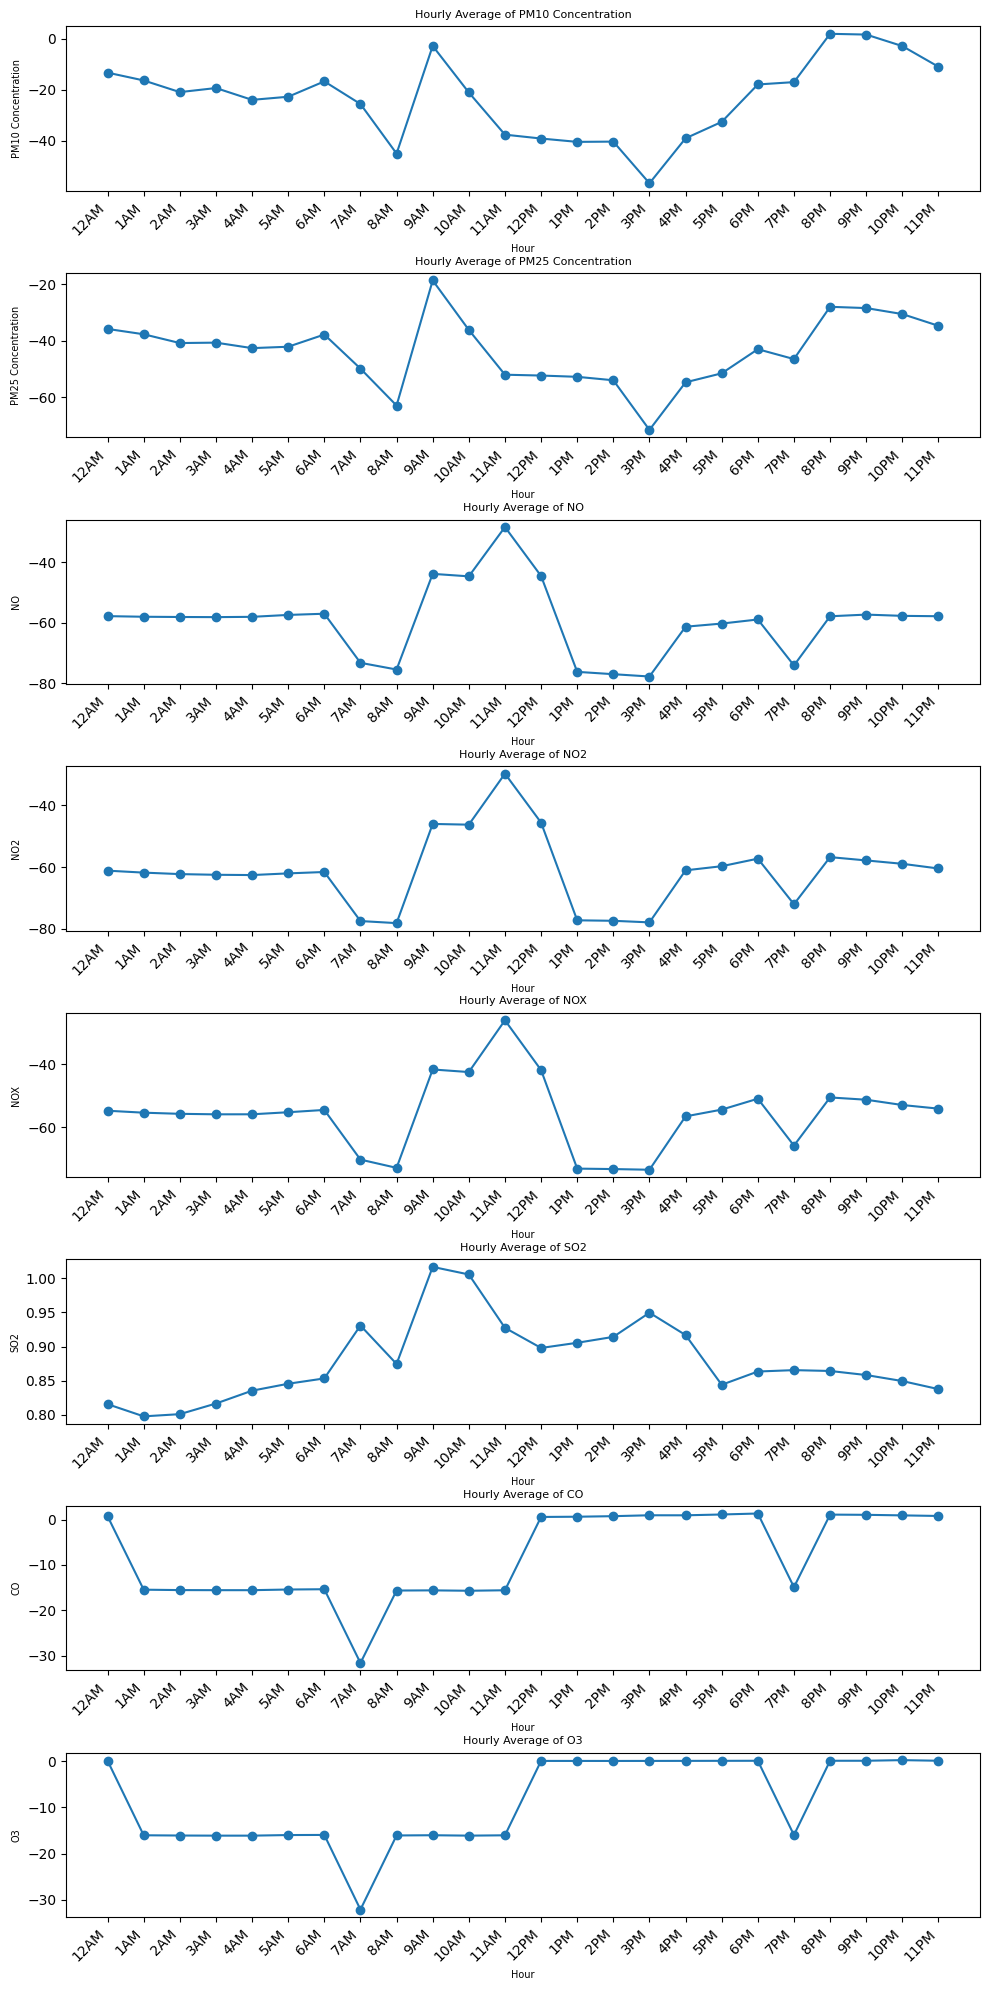

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pandas_df['Month'] = pd.to_numeric(pandas_df['Hour'], errors='coerce')

plt.figure(figsize=(10, 20), dpi=100)

for i, var in enumerate(variables):
    plt.subplot(len(variables), 1, i + 1)

    monthly_avg = pandas_df.groupby('Hour')[var].mean()

    plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')

    plt.title(f'Hourly Average of {var}', fontsize=8)
    plt.xlabel('Hour', fontsize=7)
    plt.ylabel(var, fontsize=7)

    plt.xticks(
        np.arange(24),  # Assuming hours are 0-23
        [f"{h % 12 or 12}{'AM' if h < 12 else 'PM'}" for h in range(24)],
        rotation=45,  # Rotate labels 45 degrees
        ha='right'  # Align labels to the right
    )

    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()